<a href="https://colab.research.google.com/github/chinmay-routray-github/AI-ChatBots/blob/main/ChatBot_feedforwardNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import nltk
from nltk.stem.porter import PorterStemmer
import json
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt


In [2]:
class Utils:

  # removing punctuations
  @staticmethod
  def remove_punctuations(word_list):
    punctuactions = [ '?', ',', "'", '!', ':', '-', '=', '.', '#']
    for punc in punctuactions:
      if(punc in word_list):
        word_list.remove(punc)
    return word_list

  @staticmethod
  def tokenization(sentence : str):
    return Utils.remove_punctuations(sentence.split(' '))

  @staticmethod
  def stemmer(word):
    return PorterStemmer().stem(word.lower())

  # for getting bag_of_words
  @staticmethod
  def bag_of_words(sentence, all_words):

    # getting all words from input sentence
    sentence_words = []
    sentence_words.extend(Utils.tokenization(sentence))

    # stemming those words
    sentence_words = [Utils.stemmer(w) for w in sentence_words]

    # getting bag of words
    bag_of_words = torch.zeros(len(all_words))
    for idx, word in enumerate(all_words):
      if(word in sentence_words):
        bag_of_words[idx] = 1
    return bag_of_words


  # for extracting from file prior training
  @staticmethod
  def word_extractor(all_lines):
    all_words = []

    # getting all words
    for line in all_lines:
      all_words.extend(Utils.tokenization(line))

    # getting all unique words
    all_words = [Utils.stemmer(word) for word in all_words]
    all_words = sorted(set(all_words))
    return all_words


Verification of Utils class

In [3]:
sen = "I m the man. What do you think ?"
# m = ["organize", "organization"]
l = Utils.tokenization(sen)
# l = [Utils.stemmer(w) for w in l]
print(l)

['I', 'm', 'the', 'man.', 'What', 'do', 'you', 'think']


Creating the training datatset

In [4]:

# reading the input data file
filepath = r"/content/intents.json"
with open(filepath, 'r') as f:
  intent = json.load(f)

# creating input-label and input-output dictionary
label_dict = {}
io_dict = {}
for i in intent['intents']:
  label_dict[ i['tag' ]] = i['patterns']

for j in intent['intents']:
  io_dict[ j['tag']] = j['responses']

# getting all words from input-label dictionary
all_sentences = []
for key in label_dict:
  all_sentences.extend(label_dict[key])

all_words = Utils.word_extractor(all_sentences)


# creating the input data
x_train = []
for sentence in all_sentences:
  x_train.append(Utils.bag_of_words(sentence, all_words))


# creating output labels
y_train = []
labels = []
idx = 0
for key in label_dict:
  for i in range(len(label_dict[key])):
    y_train.append(idx)
  labels.append(idx)
  idx += 1
y_train = torch.as_tensor(y_train)

print(y_train.shape, len(x_train))


torch.Size([26]) 26


Designing the Neural Network

In [5]:
# our neural network has 2 hidden layers, 1 output layer and ReLU activation
class NeuralNet(nn.Module):

  def __init__(self, input_size, hidden_size, num_class):
    super(NeuralNet, self).__init__()
    self.l1 = nn.Linear(input_size, hidden_size)
    self.l2 = nn.Linear(hidden_size, hidden_size)
    self.l3 = nn.Linear(hidden_size, num_class)
    self.relu = nn.ReLU()

  def forward(self, x_in):
    out = self.l1(x_in)
    out = self.relu(out)
    out = self.l2(out)
    out = self.relu(out)
    out = self.l3(out)
    return out

Initializing the hyper-parameters

In [6]:

# setting the hyper-parameters
num_epochs = 1000
batch_size = 8
learning_rate = 0.001
input_size = len(x_train[0])
hidden_size = 8
output_size = len(labels)
print(input_size, hidden_size, output_size)

57 8 7


Pre-training Procedures

In [7]:

from torch.utils.data import Dataset, DataLoader

class ChatDataset(Dataset):

  def __init__(self):
    self.n_samples = len(x_train)
    self.x_data = x_train
    self.y_data = y_train

  def __getitem__(self, idx):
    return self.x_data[idx], self.y_data[idx]

  def __len__(self):
    return self.n_samples


dataset = ChatDataset()
train_loader = DataLoader(dataset = dataset, batch_size = batch_size,
                          shuffle = True, num_workers=0)

# device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
# If nvidia gpu is not available
device = torch.device('cpu')

# Instantiating our Neural net
model = NeuralNet(input_size, hidden_size, output_size).to(device)

# Loss function and optimizer
cost_f = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)


Validating the DataLoader

In [ ]:
for (words, label) in train_loader:
  print((words, label))


Training our Model

Epoch : 100/1000  Loss : 0.8255
Epoch : 200/1000  Loss : 0.1344
Epoch : 300/1000  Loss : 0.1031
Epoch : 400/1000  Loss : 0.0042
Epoch : 500/1000  Loss : 0.0038
Epoch : 600/1000  Loss : 0.0008
Epoch : 700/1000  Loss : 0.0010
Epoch : 800/1000  Loss : 0.0012
Epoch : 900/1000  Loss : 0.0012
Epoch : 1000/1000  Loss : 0.0005
Traing complete... 
 with Final loss : 0.0005
saving the trained model... file saved to trained_model.pth


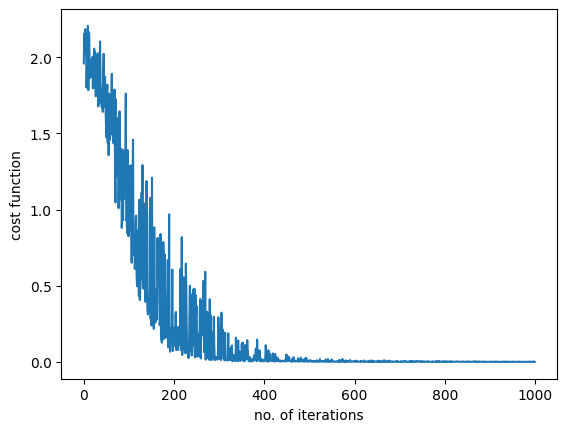

In [9]:
t = []
s = []
# Training the model
for epoch in range(num_epochs):
  n = 0
  for (words, label) in train_loader:
    words = words.to(device)
    label = label.to(device)

    # forward propagation
    output = model(words)
    loss = cost_f(output, label)

    #backward propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if(n == 3):
      t.append(loss.item())
    n += 1
  if((epoch+1) % 100 == 0):
      print(f"Epoch : {epoch+1}/{num_epochs}  Loss : {loss.item():.4f}")

  s.append(epoch)

print(f"Traing complete... \n with Final loss : {loss.item():.4f}")


# saving the trained model
data ={
    'model_state' : model.state_dict(),
    "input_size" : input_size,
    "hidden_size" : hidden_size,
    "output_size" : output_size,
    "word_collection" : all_words,
    "labels" : labels
}

FILE = "trained_model.pth"
torch.save(data, FILE)

print(f"saving the trained model... file saved to {FILE}")

# generating loss versus no. of iterations
plt.plot(s,t)
plt.xlabel("no. of iterations")
plt.ylabel("cost function")
plt.show()

Designing the output

In [10]:
data = torch.load(FILE)
input_size = data['input_size']
hiddent_size = data['hidden_size']
output_size = data['output_size']
all_words = data['word_collection']
labels = data['labels']
model_state = data['model_state']

# utilizing the model
model = NeuralNet(input_size, hidden_size, output_size).to(device)
model.load_state_dict(model_state)
model.eval()

# This is for generating stand-alone response
# sen = "fuck off"
# x = Utils.bag_of_words(sen, all_words)
# o = model(x)

# output = torch.softmax(o, dim=0).tolist()
# tag = output.index(max(output)) if max(output) > 0.45 else 'Please elaborate'
# tag

# for idx,key in enumerate(io_dict):
#   if(idx == tag):
#     print(io_dict[key][random.randint(0,len(io_dict[key])-1)])


# Begin the chat
print("Hi, I m Tito. Chat with me or enter quit to stop.")

while True:

  # getting the question
  sen = input("You :").lower()
  if(sen == 'quit'):
    break
  x = Utils.bag_of_words(sen, all_words)
  o = model(x)

  output = torch.softmax(o, dim=0).tolist()
  tag = output.index(max(output)) if max(output) > 0.45 else 'Please elaborate...'
  if(tag == 'Please elaborate...'):
    print(tag)
    continue

  # Bot reply
  for idx,key in enumerate(io_dict):
    if(idx == tag):
      print(f"Tito : {io_dict[key][random.randint(0,len(io_dict[key])-1)]}")

Hi, I m Tito. Chat with me or enter quit to stop.
You :Hey Tito!
Tito : Hello, thanks for visiting
You :How are you?
Tito : Hi there, how can I help?
You :I want something.
Tito : Hi there, what can I do for you?
You :I want tea.
Tito : Hi there, what can I do for you?
You :Give me money.
Please elaborate...
You :Bye
Tito : Have a nice day
You :Quit


Resources :

1 - https://www.youtube.com/watch?v=RpWeNzfSUHw&ab_channel=PatrickLoeber

2 - https://github.com/patrickloeber/pytorch-chatbot